# STEP 3:  Word by word text generator with rnn using keras

In [1]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.utils.data_utils import get_file
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import os

Using TensorFlow backend.


# Details of implementation (Functions):
## (You can find below the using of this functions for man and woman)


In [2]:
class Data(object):
    pass

### Some global vars: maxlen for maximum length of sentence, and step for the Vectorization.

In [3]:
maxlen = 30
step = 3
print("maxlen:",maxlen,"step:", step)

maxlen: 30 step: 3


## A function that creates the model, first it read the text file with the data, process the data for the model, does Vectorization, build the model with 2 stacked LSTM, and return the created model. If we have a pre-made model data on file, we load it.

### We use softmax for the Activation function. The softmax function squashes the outputs of each unit to be between 0 and 1, just like a sigmoid function. But it also divides each output such that the total sum of the outputs is equal to 1 (check it on the figure above). The output of the softmax function is equivalent to a categorical probability distribution, it tells you the probability that any of the classes are true.



### We use 2 stacked LSTM. LSTM is Long-Short Term Memory layer.
### The original LSTM model is comprised of a single hidden LSTM layer followed by a standard feedforward output layer. The Stacked LSTM is an extension to this model that has multiple hidden LSTM layers where each layer contains multiple memory cells. Stacked LSTMs are now a stable technique for challenging sequence prediction problems. A Stacked LSTM architecture can be defined as an LSTM model comprised of multiple LSTM layers. An LSTM layer above provides a sequence output rather than a single value output to the LSTM layer below. Specifically, one output per input time step, rather than one output time step for all input time steps.



### We use categorical_crossentropy as the losing function on the RNN.

### We use rmsprop as the optimizer; rmspror divide	the	learning rate for a	weight	by	a running average of the	magnitudes of recent gradients for that	weight.	

In [4]:
def build_model(type, data):
    path = type + ".txt"
    filepath = type + "_weights.hdf5"
    try: 
        text = open(path).read().lower()
    except UnicodeDecodeError:
        import codecs
        text = codecs.open(path, encoding='utf-8').read().lower()

    print('corpus length:', len(text))
    data.num_sen = sum(1 for line in codecs.open(path, encoding='utf-8'))
    print('number of sentencase: ', data.num_sen)
    data.chars = set(text)
    data.words = set(text.lower().split())

    print("total number of unique words",len(data.words))
    print("total number of unique chars", len(data.chars))

    data.word_indices = dict((c, i) for i, c in enumerate(data.words))
    data.indices_word = dict((i, c) for i, c in enumerate(data.words))

    sentences = []
    next_words = []
    next_words= []
    sentences1 = []
    list_words = []
    sentences2=[]
    
    data.list_words=text.lower().split()

    for i in range(0,len(data.list_words)-maxlen, step):
        sentences2 = ' '.join(data.list_words[i: i + maxlen])
        sentences.append(sentences2)
        next_words.append((data.list_words[i + maxlen]))
    print('nb sequences(length of sentences):', len(sentences))
    print("length of next_word",len(next_words))

    print('Vectorization...')
    data.X = np.zeros((len(sentences), maxlen, len(data.words)), dtype=np.bool)
    data.y = np.zeros((len(sentences), len(data.words)), dtype=np.bool)
    for i, sentence in enumerate(sentences):
        for t, word in enumerate(sentence.split()):
            data.X[i, t, data.word_indices[word]] = 1
        data.y[i, data.word_indices[next_words[i]]] = 1

    print('Build model...')
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(maxlen, len(data.words))))
    model.add(Dropout(0.2))
    model.add(LSTM(512, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(len(data.words)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

    if os.path.isfile(filepath):
       model.load_weights(filepath)
    return model

### Helper function to sample an index from a probability array

In [5]:
def sample(a, temperature=1.0):
    a = np.log(a) / temperature
    dist = np.exp(a)/np.sum(np.exp(a)) 
    choices = range(len(a)) 
    return np.random.choice(choices, p=dist)

## A function that train the model, we use a checkpoint to save the weights to file because it takes a lot of time to make a full train. we update the file only if the loss get a better score.

### We use validation_split=0.05, for taking 5% of the data to be test data. We use batch_size=128, Batch size defines a number of samples that going to be propagated through the network. we found that 128 give us a good result, after some tests. with the limit of running time.

In [6]:
def train_model(model,data,type,epochs):
    filepath = type + "_weights.hdf5" 
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    fit = model.fit(data.X, data.y, validation_split=0.05, batch_size=128, epochs=epochs, callbacks=callbacks_list, verbose=1)
    return fit.history

## Function for print plot of how accuracy and loss change over training epochs

In [7]:
def print_summery(history):
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left');
    plt.show()
    
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left');
    plt.show()

## Function for create sentences. it take a seed from the data, and every time choose what will be the next word.

In [8]:
def create_sentence(data, model, diversity = 1.2, num_of_words = 25, verbose = 1):
    start_index = random.randint(0, len(data.list_words) - maxlen - 1)
    if verbose == 1:
        print("Create Sentence..")
        print('Diversity:', diversity)
    generated = ''
    sentence = data.list_words[start_index: start_index + 10]
    seed = ' '.join(sentence)
    if verbose == 1:
        print('Generating with seed:')
        print(seed)       
        
    for i in range(num_of_words):
        x = np.zeros((1, maxlen, len(data.words)))
        for t, word in enumerate(sentence):
            x[0, t, data.word_indices[word]] = 1.

        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_word = data.indices_word[next_index]
        generated += next_word
        generated += " "
        del sentence[0]
        sentence.append(next_word)
    if verbose == 1:
        print("The sentence:")
        print(generated)
    return generated

# Builds models for man and woman, and get sentences :

# Men Model :

In [27]:
type = "man"
dataMan = Data()

### Build the model: if we have pre-train data, load it

In [28]:
model = build_model(type, dataMan)

corpus length: 345609
number of sentencase:  18643
total number of unique words 12885
total number of unique chars 111
nb sequences(length of sentences): 23880
length of next_word 23880
Vectorization...
Build model...


### Train the model with 15 iteration (we found that 15 give good result, and no so much time. we can increase the number and get better result, but it take more time). we save the best result to file, if we want to load it fast without need to wait for train. 

In [11]:
history = train_model(model,dataMan,type,15)

Train on 22686 samples, validate on 1194 samples
Epoch 1/15
22656/22686 [============================>.] - ETA: 4s - loss: 7.8258 - acc: 0.0334 
Epoch 00001: loss improved from inf to 7.82544, saving model to man_weights.hdf5
22686/22686 [==============================] - 3185s 140ms/step - loss: 7.8254 - acc: 0.0334 - val_loss: 7.5410 - val_acc: 0.0243
Epoch 2/15
22656/22686 [============================>.] - ETA: 4s - loss: 7.5057 - acc: 0.0347 
Epoch 00002: loss improved from 7.82544 to 7.50538, saving model to man_weights.hdf5
22686/22686 [==============================] - 3108s 137ms/step - loss: 7.5054 - acc: 0.0346 - val_loss: 7.5920 - val_acc: 0.0243
Epoch 3/15
22656/22686 [============================>.] - ETA: 4s - loss: 7.4281 - acc: 0.0352 
Epoch 00003: loss improved from 7.50538 to 7.42825, saving model to man_weights.hdf5
22686/22686 [==============================] - 3192s 141ms/step - loss: 7.4282 - acc: 0.0351 - val_loss: 7.5911 - val_acc: 0.0243
Epoch 4/15
22656/22686

### Print plot of how accuracy and loss change over training epochs

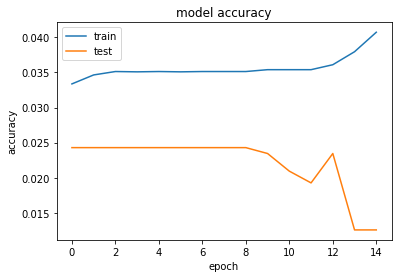

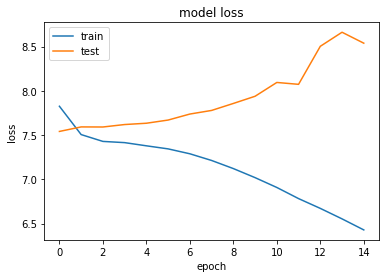

In [12]:
print_summery(history)

### Create sentences, print the first 5 for example

In [29]:
sentences = []
for i in range(int(0.3 * dataMan.num_sen)):
    if i in range(5):
        print("Example " , i, ": ")
      else:
        sen = create_sentence(dataMan, model, diversity = 1.2, num_of_words = 25, verbose = 0)
    sentences.append(sen)  

Example  0 : 
Create Sentence..
Diversity: 1.2
Generating with seed:
לי ולא הופיע מאז אם הוא שם אותו אנחנו מקבלים
The sentence:
עד אותה עוד בלי eq? מהוד אל b לתרגול תפסיק ישיבות עכשיו בזה שלהם בדרך האלגוריתם הבנתי יותר מדהים עבודה שאני כלום פשוט ברמה תבור 
Example  1 : 
Create Sentence..
Diversity: 1.2
Generating with seed:
בקשת כי אתה לא מבין כלום הוא כל עונה שם
The sentence:
אתה הראשון איך המחשב זונה זהו עשית שבוע איתך זונות יודע סבבה סהכ הוא שטיות חושב בעיה אלפין הקשר העכבר? אזה הארגומנט באסמבלי תעבודה איתך 
Example  2 : 
Create Sentence..
Diversity: 1.2
Generating with seed:
תבדוק בקבוצה אולי מישהו הצליח לפתור את זה אחי בבקשה
The sentence:
הגדרנו הייתי 12 רשם לנו רוצה אך 30 נסיים (+ חחחחחחחחח רואה יא גם cse שבוע בבית שלהם פחות מצאתי 6 ולחקור סבבה זה אתה 
Example  3 : 
Create Sentence..
Diversity: 1.2
Generating with seed:
בסדר זה כמו אצלי אחי זה לא מעניין אחי נמאס
The sentence:
לפי סיימתי מאד חחחחח לך אותי? סעמק להם תביא ריק אליפות פה בעבודה הראשונה כל לשבת לעבודות ללכת חחחח עונה ל

### And save to file

In [30]:
np.save(file='man_generate.npy', arr = sentences)

# Woman Model :

In [15]:
type = "woman"
dataWoman = Data()

### Build the model: if we have pre-train data, load it

In [16]:
model = build_model(type,dataWoman)

corpus length: 131205
number of sentencase:  5418
total number of unique words 6170
total number of unique chars 92
nb sequences(length of sentences): 8722
length of next_word 8722
Vectorization...
Build model...


### Train the model with 15 iteration (we found that 15 give good result, and no so much time. we can increase the number and get better result, but it take more time). we save the best result to file, if we want to load it fast without need to wait for train. 

In [17]:
history = train_model(model,dataWoman,type,15)

Train on 8285 samples, validate on 437 samples
Epoch 1/15
8192/8285 [============================>.] - ETA: 8s - loss: 7.5990 - acc: 0.0264 
Epoch 00001: loss improved from inf to 7.59855, saving model to woman_weights.hdf5
8285/8285 [==============================] - 770s 93ms/step - loss: 7.5985 - acc: 0.0264 - val_loss: 7.0026 - val_acc: 0.0252
Epoch 2/15
8192/8285 [============================>.] - ETA: 8s - loss: 7.1164 - acc: 0.0293 
Epoch 00002: loss improved from 7.59855 to 7.12016, saving model to woman_weights.hdf5
8285/8285 [==============================] - 749s 90ms/step - loss: 7.1202 - acc: 0.0292 - val_loss: 7.0609 - val_acc: 0.0252
Epoch 3/15
8192/8285 [============================>.] - ETA: 8s - loss: 7.0535 - acc: 0.0300 
Epoch 00003: loss improved from 7.12016 to 7.05769, saving model to woman_weights.hdf5
8285/8285 [==============================] - 736s 89ms/step - loss: 7.0577 - acc: 0.0301 - val_loss: 7.1116 - val_acc: 0.0252
Epoch 4/15
8192/8285 [==============

### Print plot of how accuracy and loss change over training epochs

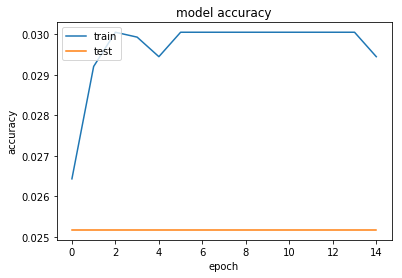

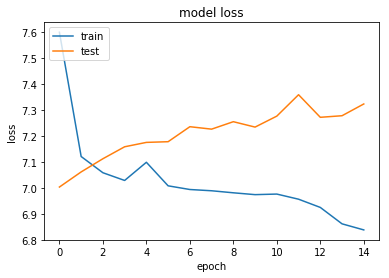

In [18]:
print_summery(history)

### Create sentences, print the first 5 for example

In [22]:
sentences = []
for i in range(int(0.3 * dataWoman.num_sen)):
    if i in range(5):
        print("Example " , i, ": ")
        sen = create_sentence(dataWoman, model, diversity = 1.2, num_of_words = 25, verbose = 1)
    else:
        sen = create_sentence(dataWoman, model, diversity = 1.2, num_of_words = 25, verbose = 0)
    sentences.append(sen)  

Example  0 : 
Create Sentence..
Diversity: 1.2
Generating with seed:
אתה הולך למשחק היום? בבאר שבע? תתלבש טוב נורא קר
The sentence:
יקר.אם בסופר בכשרות עכשיו הצפי, אתה מקיף דרכי תשמור שבוע 2 עלאק אוקי ציונים? המבחן והכרנו ואיזה שיעור יהיה בקטע נסעו מחר ... יד שניה 
Example  1 : 
Create Sentence..
Diversity: 1.2
Generating with seed:
וחצי אז אוכל להגיע רק ב5 מה נשמע? טוב.מה חדש?
The sentence:
הלפטופ לא היא ותלכו אין מה היום.. 30 אתם?זה נוכל ואני לריסה.אני להוריד לא ההיא 13 סבבה של יפה.מתי הכל בשמחה, הי, אבל הולך קנסות 
Example  2 : 
Create Sentence..
Diversity: 1.2
Generating with seed:
המטלות האלה אין לי סבלנות לזה ממשש אבל מזה איך
The sentence:
דרכי? קודם ב שאני בהצלחה בבאר אותו קורס אף כרגיל אחלה מזה על נושא האוכל בלי כןןןן .אני שנשתה בחוץ היית .נמצא סגרנו עובדים.יש חם 
Example  3 : 
Create Sentence..
Diversity: 1.2
Generating with seed:
לי חתימה מתי רואים אותך השבוע ?איזה יום נוח לך?
The sentence:
מוכנה עובדת איתך נלך תבדקו התשלום? הכנת? וואי או בינתיים ולא מסכן.מחר בשבילך היי.ניפגש

### And save to file

In [24]:
np.save(file='woman_generate.npy', arr = sentences)